In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset from the data folder
df = pd.read_csv('../data/FAOSTAT_data_en_7-31-2025.csv')

# Basic cleaning and renaming
df = df.rename(columns={
    'Area': 'Country',
    'Item': 'Crop',
    'Element': 'Element',
    'Year': 'Year',
    'Value': 'Value'
})

# Keep only useful elements
filtered_df = df[df['Element'].isin([
    'Production',
    'Yield',
    'Area harvested'
])]

# Pivot to wide format (Production, Yield, Area as columns)
pivot_df = filtered_df.pivot_table(
    index=['Country', 'Crop', 'Year'],
    columns='Element',
    values='Value',
    aggfunc='mean'
).reset_index()

# Rename columns for clarity
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={
    'Production': 'Value_production',
    'Yield': 'Value_yield',
    'Area harvested': 'Value_area'
})

# Convert Year to datetime for plotting
pivot_df['Year'] = pd.to_datetime(pivot_df['Year'], format='%Y')

# Save cleaned version
cleaned_df = pivot_df.copy()


In [3]:
# Data Cleaning and Preprocessing with robust type conversion
def clean_data(df):
    # Drop unnecessary columns
    cols_to_drop = ['Domain Code', 'Domain', 'Area Code (M49)', 'Element Code', 
                   'Item Code (CPC)', 'Year Code', 'Flag', 'Flag Description', 'Note']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    
    # Rename columns for easier handling
    df = df.rename(columns={
        'Area': 'Country',
        'Element': 'Measurement',
        'Item': 'Crop',
        'Year': 'Year',
        'Unit': 'Unit',
        'Value': 'Value'
    })
    
    # Convert Year to datetime
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    
    # Robust conversion of Value column to numeric
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    
    # Drop rows with missing values in critical columns
    df = df.dropna(subset=['Value', 'Crop', 'Measurement'])
    
    # Create separate dataframes for different measurements
    area_df = df[df['Measurement'] == 'Area harvested'].copy()
    yield_df = df[df['Measurement'] == 'Yield'].copy()
    production_df = df[df['Measurement'] == 'Production'].copy()
    
    # Pivot the data with explicit numeric conversion
    area_pivot = area_df.pivot_table(index=['Country', 'Crop', 'Year'], 
                                    values='Value', aggfunc='mean').reset_index()
    yield_pivot = yield_df.pivot_table(index=['Country', 'Crop', 'Year'], 
                                      values='Value', aggfunc='mean').reset_index()
    production_pivot = production_df.pivot_table(index=['Country', 'Crop', 'Year'], 
                                                values='Value', aggfunc='mean').reset_index()
    
    # Merge the dataframes with type consistency check
    merged_df = pd.merge(
        area_pivot, 
        yield_pivot, 
        on=['Country', 'Crop', 'Year'], 
        suffixes=('_area', '_yield'),
        how='inner'  # Use inner join to ensure consistent data
    )
    
    merged_df = pd.merge(
        merged_df, 
        production_pivot, 
        on=['Country', 'Crop', 'Year'],
        how='inner'
    )
    
    merged_df = merged_df.rename(columns={'Value': 'Value_production'})
    
    # Ensure all numeric columns are float type
    numeric_cols = ['Value_area', 'Value_yield', 'Value_production']
    merged_df[numeric_cols] = merged_df[numeric_cols].astype(float)
    
    # Calculate additional metrics
    merged_df['Yield_per_area'] = merged_df['Value_yield'] / merged_df['Value_area']
    
    return merged_df

In [4]:
# Clean the data with error handling
try:
    cleaned_df = clean_data(df)
    print("Data cleaning completed successfully.")
    print("\nCleaned data shape:", cleaned_df.shape)
    display(cleaned_df.head())
except Exception as e:
    print(f"Error during data cleaning: {str(e)}")
    # If error occurs, show problematic rows
    print("\nProblematic rows:")
    display(df[df['Value'].apply(lambda x: not str(x).replace('.','',1).isdigit())])

Data cleaning completed successfully.

Cleaned data shape: (18179, 7)


,Country,Crop,Year,Value_area,Value_yield,Value_production,Yield_per_area
0,Burundi,Bananas,2000-01-01,273050.0,5544.8,1513997.0,0.020307
1,Burundi,Bananas,2001-01-01,300000.0,5163.9,1549164.0,0.017213
2,Burundi,Bananas,2002-01-01,300000.0,5343.3,1602979.0,0.017811
3,Burundi,Bananas,2003-01-01,310437.0,5669.2,1759917.0,0.018262
4,Burundi,Bananas,2004-01-01,300000.0,5288.5,1586536.0,0.017628


Summary Statistics:


,Value_area,Value_yield,Value_production,Yield_per_area
count,1.817900e+04,18179.000000,1.817900e+04,1.817900e+04
mean,8.414358e+04,6662.966797,2.541628e+05,inf
std,2.832308e+05,11097.722454,8.456219e+05,NaN
min,0.000000e+00,11.100000,2.000000e-01,1.657225e-04
25%,5.500000e+02,883.550000,1.550000e+03,4.663048e-02
50%,4.796000e+03,3333.300000,1.287696e+04,6.471500e-01
75%,4.139450e+04,7980.400000,9.619600e+04,7.617747e+00
max,4.400000e+06,121648.600000,1.175644e+07,inf


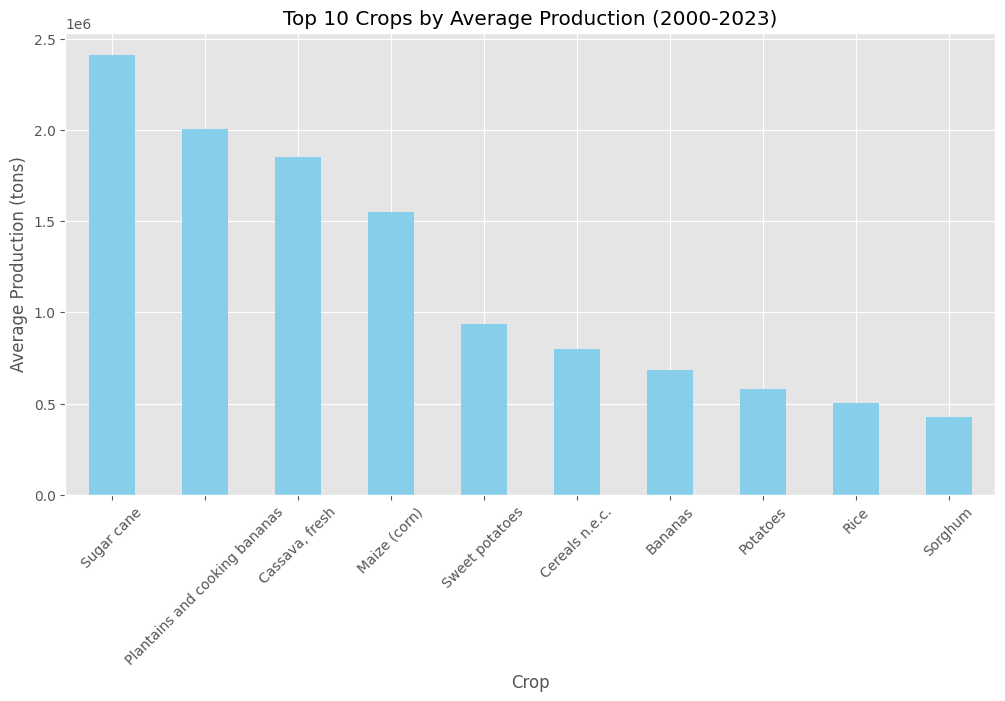

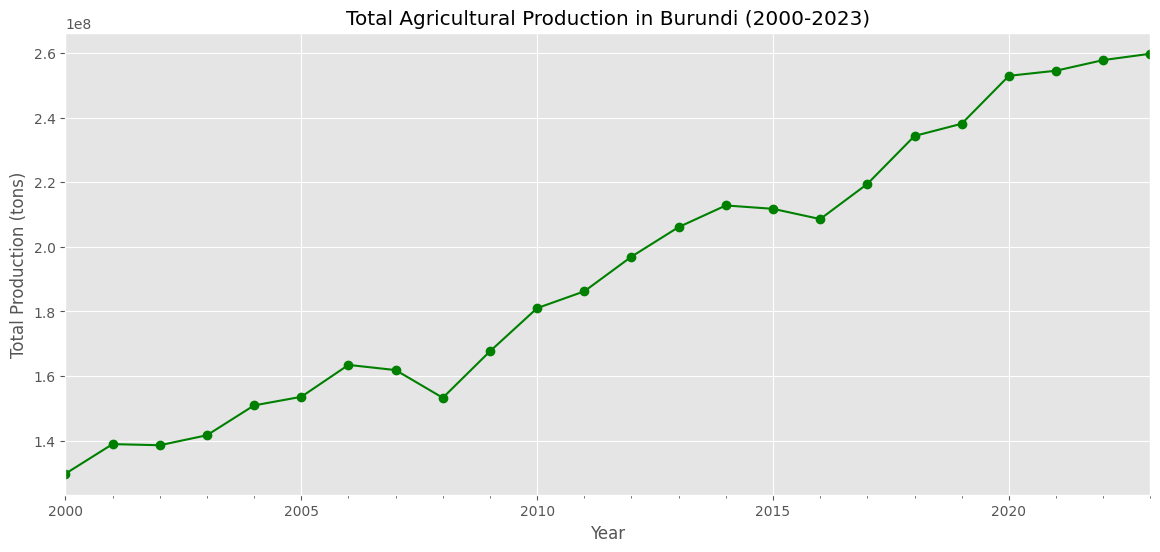

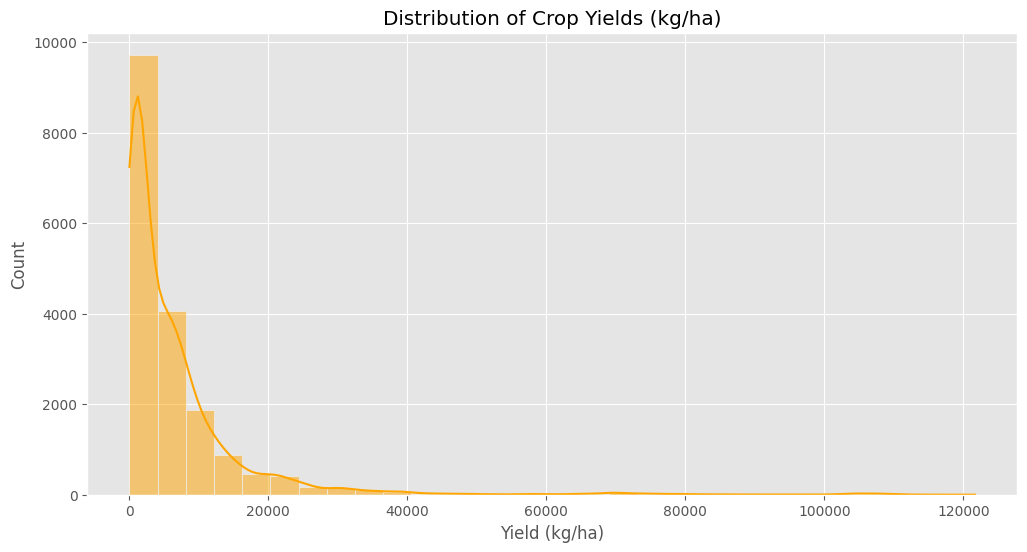

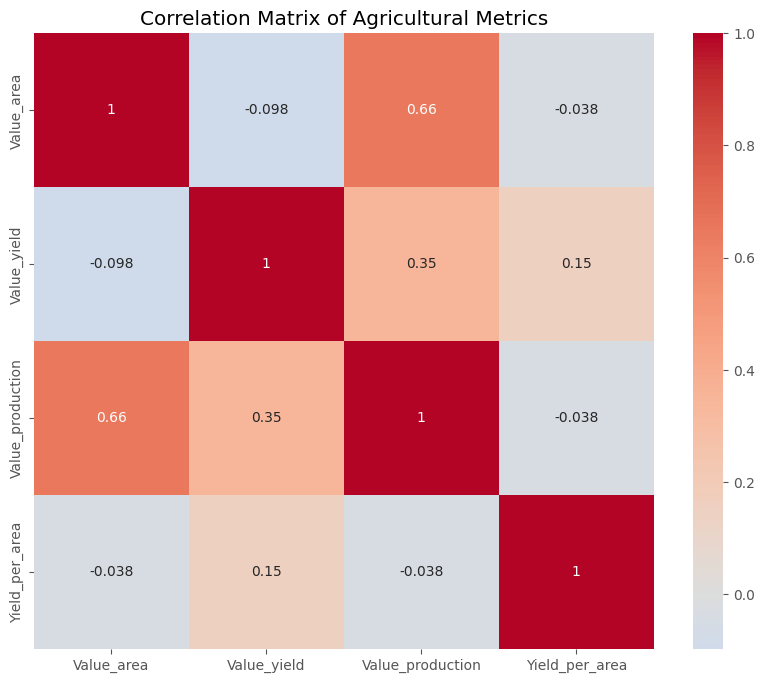

In [5]:
# Modified EDA function with error handling
def perform_eda(df):
    try:
        # Summary statistics
        print("Summary Statistics:")
        display(df.describe(include=[np.number]))
        
        # Top crops by average production with explicit numeric conversion
        top_crops = df.groupby('Crop')['Value_production'].mean().sort_values(ascending=False).head(10)
        
        plt.figure(figsize=(12, 6))
        top_crops.plot(kind='bar', color='skyblue')
        plt.title('Top 10 Crops by Average Production (2000-2023)')
        plt.ylabel('Average Production (tons)')
        plt.xlabel('Crop')
        plt.xticks(rotation=45)
        plt.show()
        
        # Time series of total production
        total_prod = df.groupby('Year')['Value_production'].sum()
        
        plt.figure(figsize=(14, 6))
        total_prod.plot(kind='line', marker='o', color='green')
        plt.title('Total Agricultural Production in Burundi (2000-2023)')
        plt.ylabel('Total Production (tons)')
        plt.xlabel('Year')
        plt.grid(True)
        plt.show()
        
        # Distribution of yields
        plt.figure(figsize=(12, 6))
        sns.histplot(df['Value_yield'], bins=30, kde=True, color='orange')
        plt.title('Distribution of Crop Yields (kg/ha)')
        plt.xlabel('Yield (kg/ha)')
        plt.show()
        
        # Correlation matrix
        numeric_cols = ['Value_area', 'Value_yield', 'Value_production', 'Yield_per_area']
        corr_matrix = df[numeric_cols].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Agricultural Metrics')
        plt.show()
        
    except Exception as e:
        print(f"Error during EDA: {str(e)}")
        # Identify non-numeric values if that's the issue
        if 'could not convert string to float' in str(e):
            print("\nNon-numeric values found in:")
            for col in ['Value_area', 'Value_yield', 'Value_production']:
                non_numeric = df[col].apply(lambda x: not isinstance(x, (int, float)))
                if non_numeric.any():
                    print(f"\nColumn '{col}' has non-numeric values at indices:")
                    display(df[non_numeric])

# Perform EDA with error handling
perform_eda(cleaned_df)

In [6]:
# Feature Engineering and Machine Learning Preparation

def prepare_ml_data(df, target_crop='Bananas'):
    # Filter data for the target crop
    crop_data = df[df['Crop'] == target_crop].copy()
    
    # Create time-based features
    crop_data['Year_num'] = crop_data['Year'].dt.year
    crop_data['Time_index'] = range(len(crop_data))
    
    # Lag features for time series
    crop_data['Production_lag1'] = crop_data['Value_production'].shift(1)
    crop_data['Yield_lag1'] = crop_data['Value_yield'].shift(1)
    crop_data['Area_lag1'] = crop_data['Value_area'].shift(1)
    
    # Drop rows with missing values from lag features
    crop_data = crop_data.dropna()
    
    # Define features and target
    X = crop_data[['Year_num', 'Time_index', 'Value_area', 'Value_yield', 
                   'Production_lag1', 'Yield_lag1', 'Area_lag1']]
    y = crop_data['Value_production']
    
    return X, y, crop_data

# Prepare data for Bananas production prediction
X, y, banana_data = prepare_ml_data(cleaned_df, 'Bananas')

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (273, 7)
Test set shape: (69, 7)


Training RMSE: 87922.48
Test RMSE: 520327.77
Training R²: 0.99
Test R²: 0.86


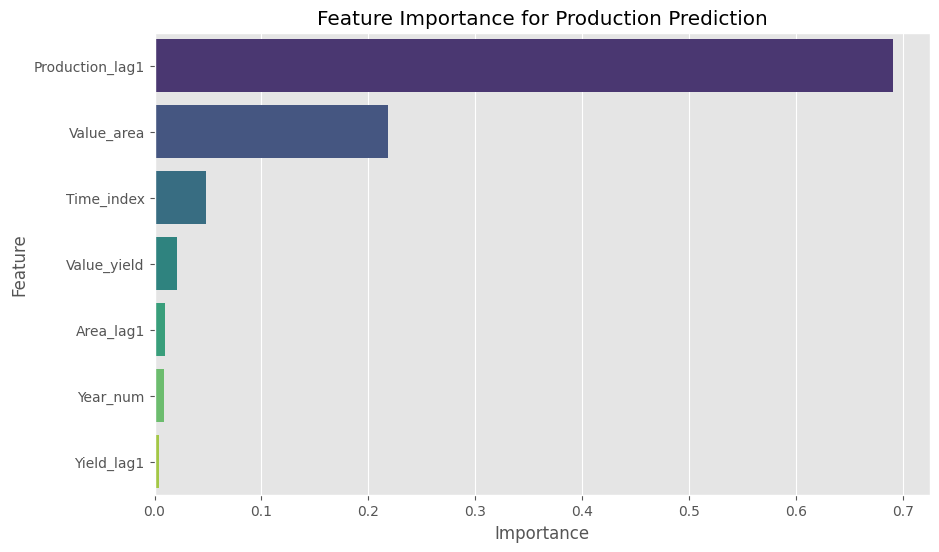

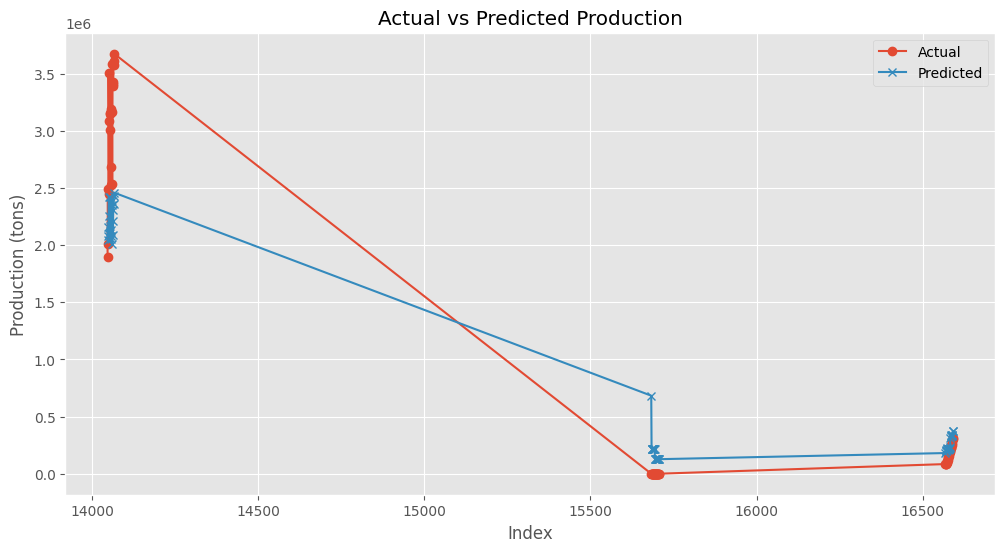

In [7]:
# Machine Learning Model - Random Forest Regressor

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Training R²: {train_r2:.2f}")
    print(f"Test R²: {test_r2:.2f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title('Feature Importance for Production Prediction')
    plt.show()
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred_test, label='Predicted', marker='x')
    plt.title('Actual vs Predicted Production')
    plt.ylabel('Production (tons)')
    plt.xlabel('Index')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, y_pred_test

# Train and evaluate the model
production_model, y_pred = train_and_evaluate_model(X_train, X_test, y_train, y_test)